In [1]:
using Revise
using SciBmad, CairoMakie
set_theme!(theme_latexfonts())

Precompiling packages...
  44793.2 ms  ✓ SciBmad
  1 dependency successfully precompiled in 45 seconds. 111 already precompiled.


In [2]:
include("esr-v6.3.1-noDA.jl");

In [4]:
@time twiss(ring);

  0.338664 seconds (5.60 M allocations: 297.685 MiB, 13.56% gc time)


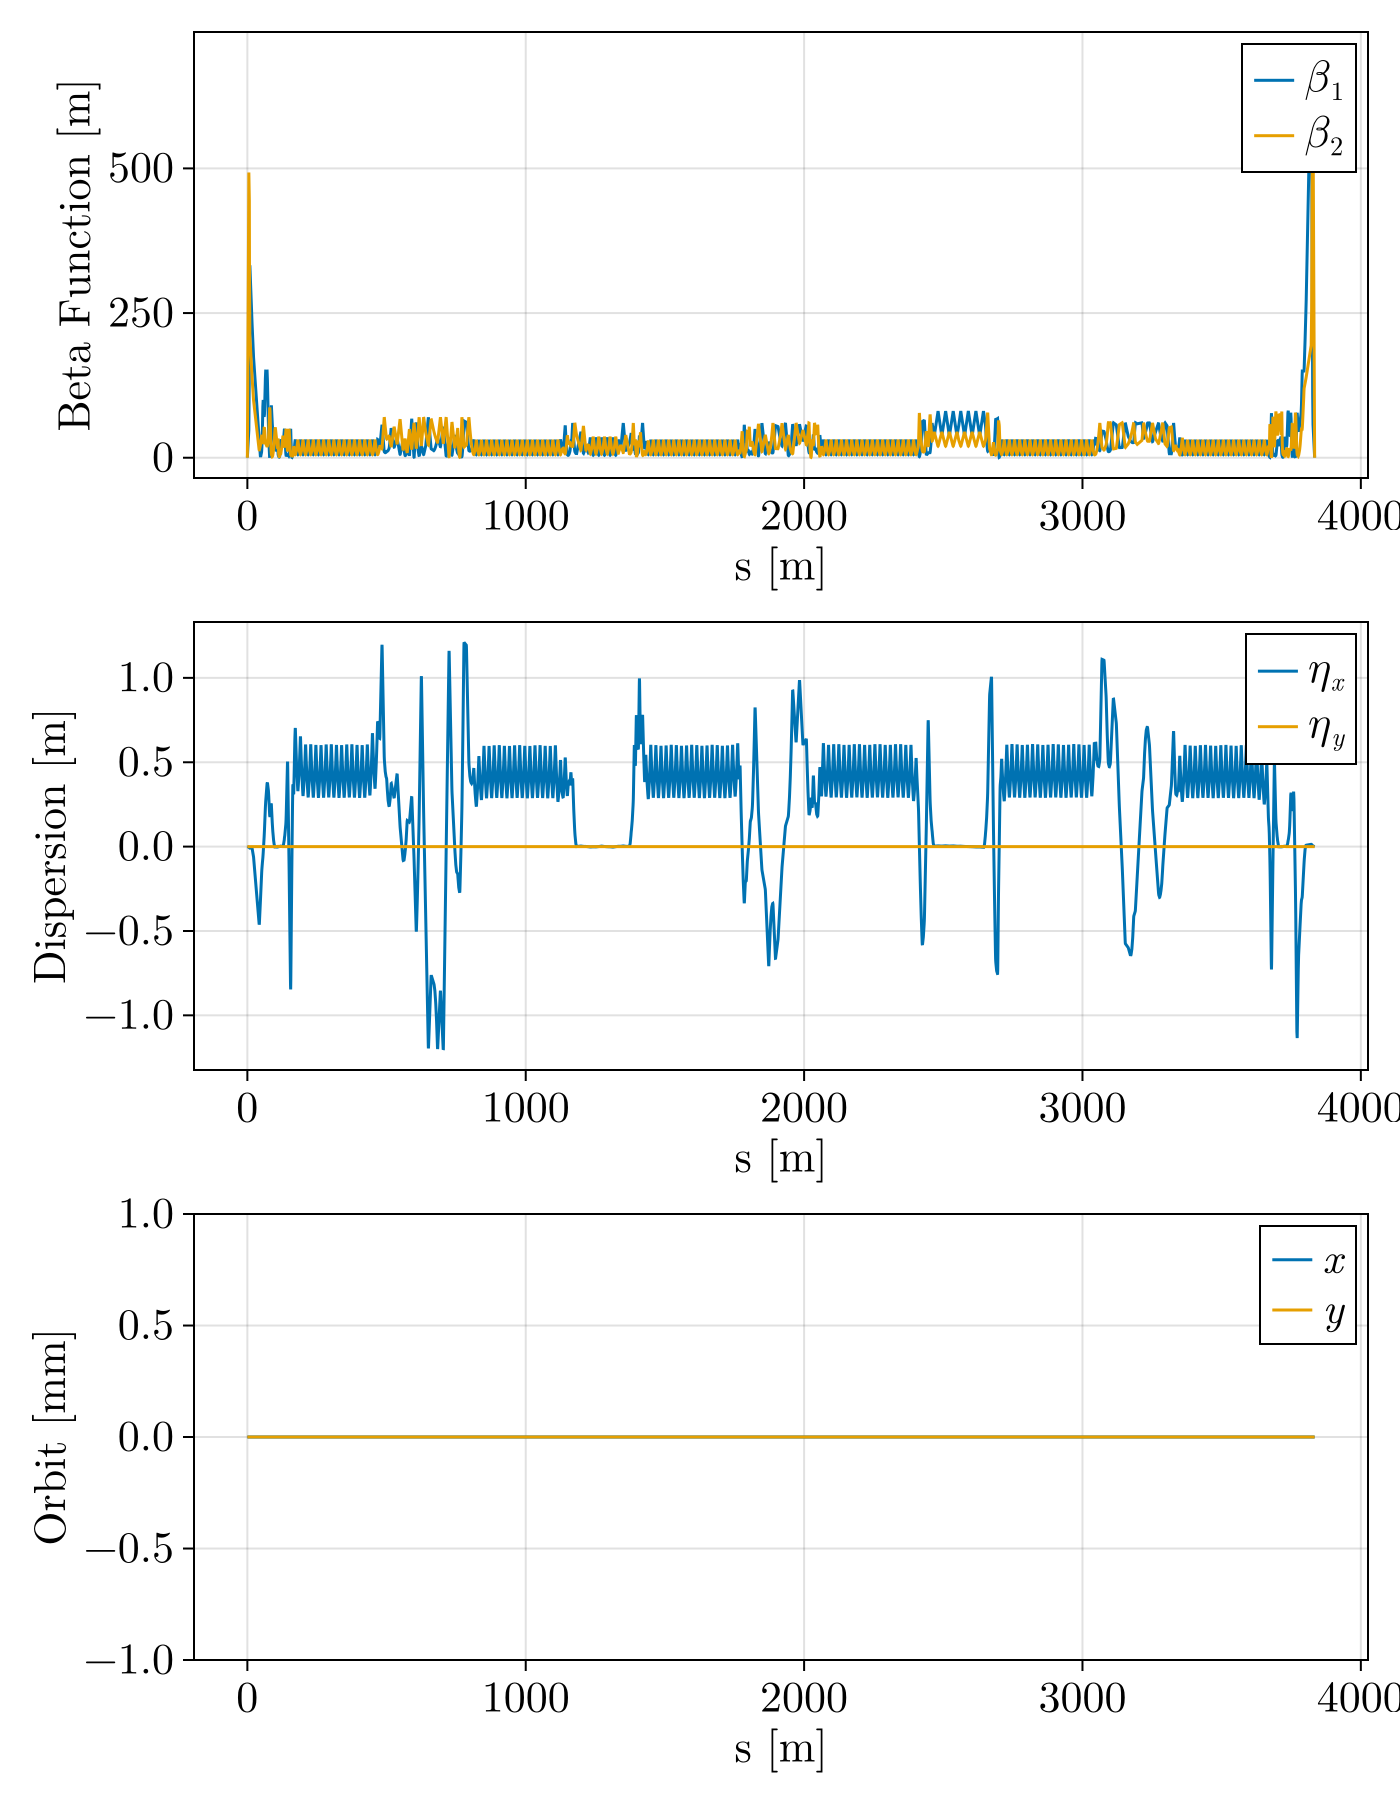

In [5]:
tw = twiss(ring)
t = tw.table

eta_1 = map(x->x[6], t.orbit_x)
eta_2 = map(x->x[6], t.orbit_y)

# Plot the betas, dispersion, orbit:
f = Figure(fontsize=22, size=(700,3*300));
ax1 = Axis(f[1, 1], xlabel="s [m]", ylabel="Beta Function [m]");
ax2 = Axis(f[2, 1], xlabel="s [m]", ylabel="Dispersion [m]");
ax3 = Axis(f[3, 1], xlabel="s [m]", ylabel="Orbit [mm]");

lines!(ax1, t.s, t.beta_1, label=L"\beta_1"); 
lines!(ax1, t.s, t.beta_2, label=L"\beta_2");
lines!(ax2, t.s, eta_1, label=L"\eta_x"); 
lines!(ax2, t.s, eta_2, label=L"\eta_y");
lines!(ax3, t.s, scalar.(t.orbit_x), label=L"x"); 
lines!(ax3, t.s, scalar.(t.orbit_y), label=L"y");

axislegend(ax1, position=:rt);
axislegend(ax2, position=:rt);
axislegend(ax3, position=:rt);

display(f);

In [7]:
# Tunes:
GTPSA.show_eps=1e-9
tw.tunes

3-element StaticArraysCore.SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=1)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   8.0000003224447711e-02      0      0   0   0   0   0   0
--------------------------------------------------------------------
   2:   1.3999999903914259e-01      0      0   0   0   0   0   0
--------------------------------------------------------------------
   3:  -2.3124330713838033e+00      1      0   0   0   0   0   1


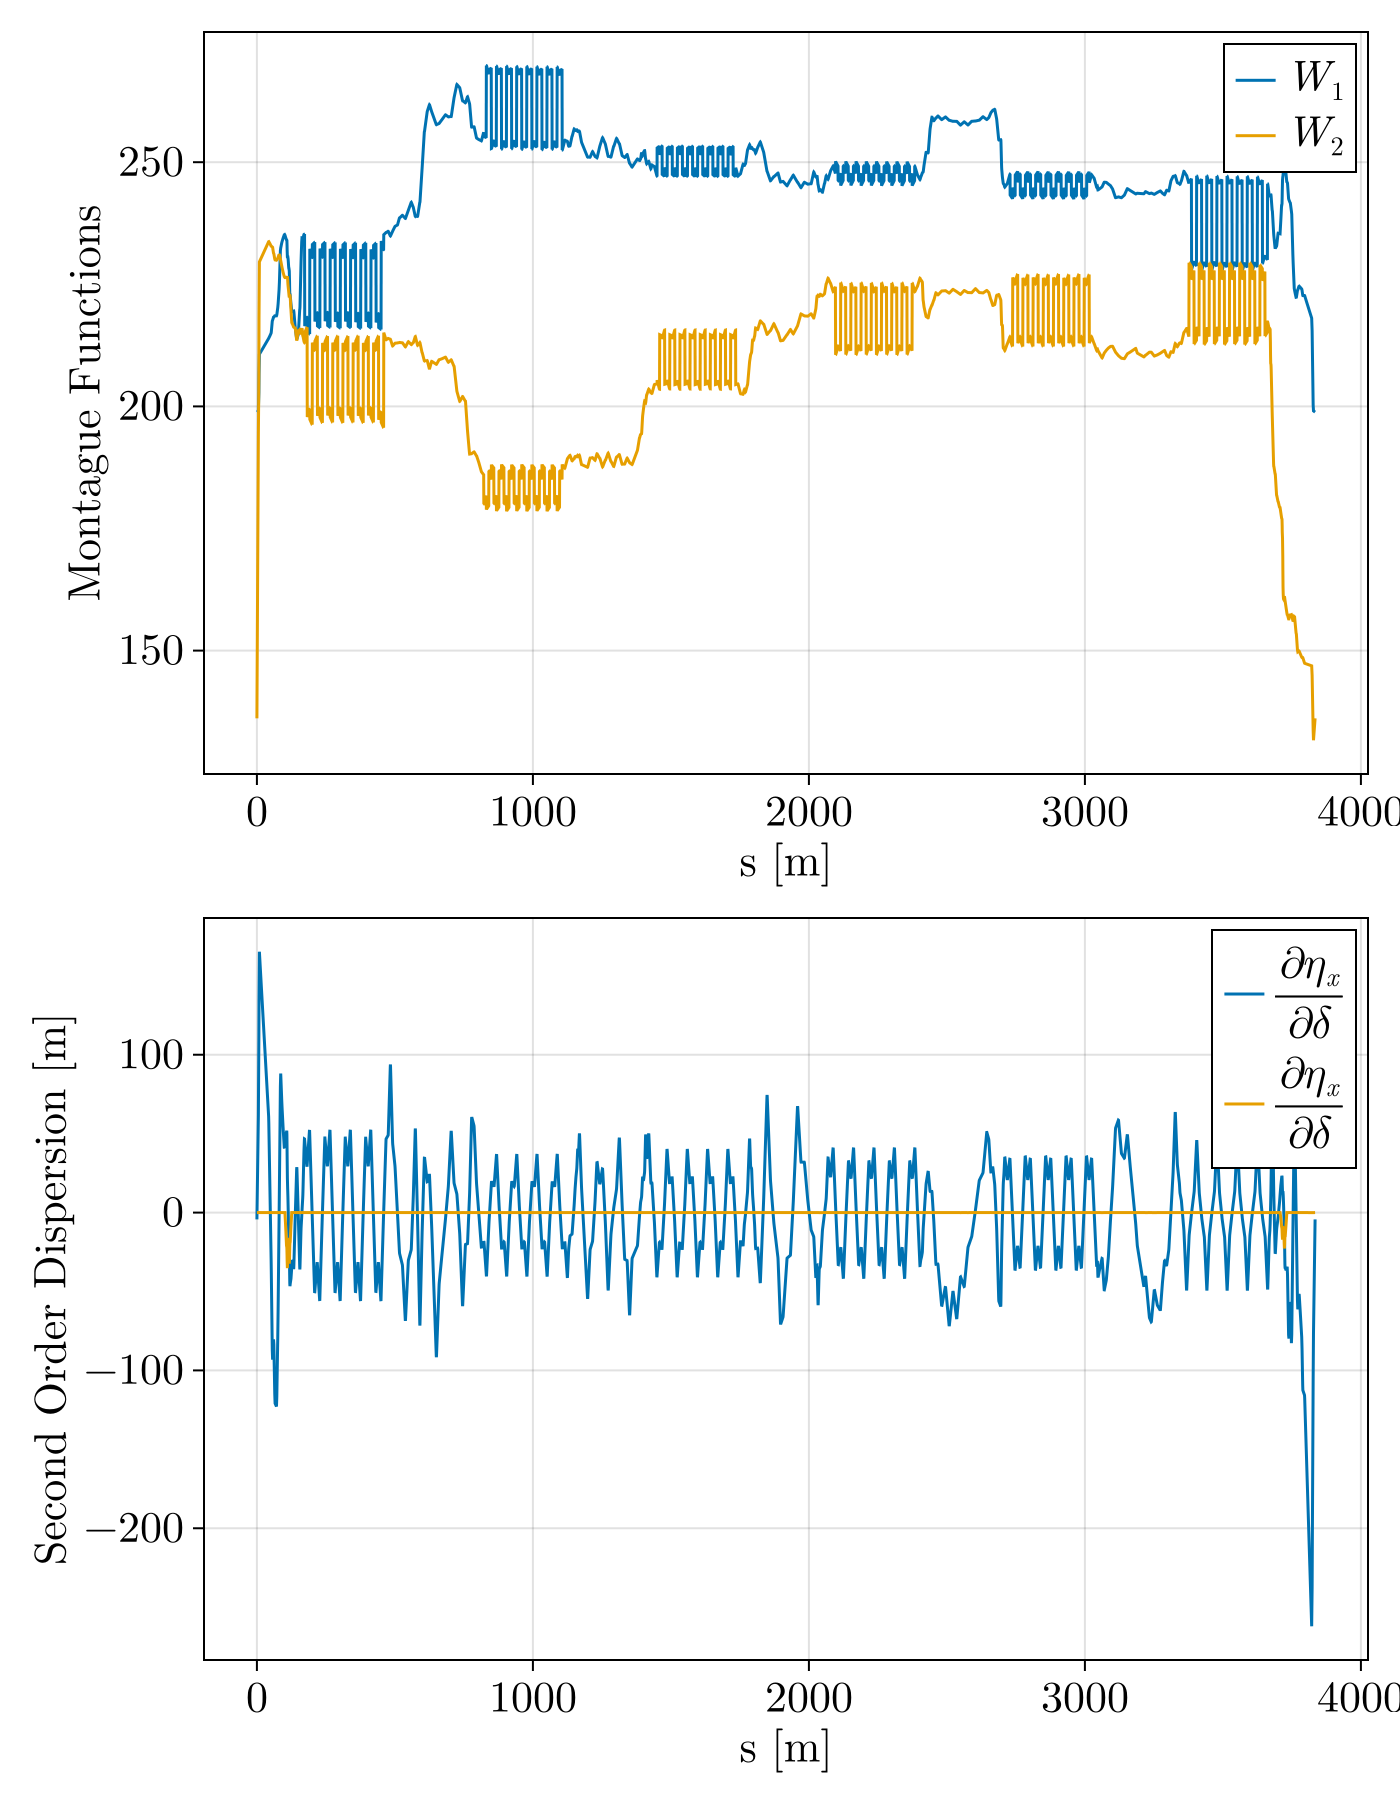

In [8]:
# Second order
tw2 = twiss(ring; GTPSA_descriptor=Descriptor(6, 2)) #, at=filter(x->x.kind=="Marker", ring.line))
t2 = tw2.table

deta_ddelta_x = map(x->x[[0,0,0,0,0,2]], t2.orbit_x)
deta_ddelta_y = map(x->x[[0,0,0,0,0,2]], t2.orbit_y)
beta_1 = scalar.(t2.beta_1)
beta_2 = scalar.(t2.beta_2)
dbeta_ddelta_1 = map(x->x[[0,0,0,0,0,1]], t2.beta_1)
dbeta_ddelta_2 = map(x->x[[0,0,0,0,0,1]], t2.beta_2)
alpha_1 = scalar.(t2.alpha_1)
alpha_2 = scalar.(t2.alpha_2)
dalpha_ddelta_1 = map(x->x[[0,0,0,0,0,1]], t2.alpha_1)
dalpha_ddelta_2 = map(x->x[[0,0,0,0,0,1]], t2.alpha_2)
W_1 = @. sqrt((dalpha_ddelta_1-alpha_1/beta_1*dbeta_ddelta_1)^2 + (dbeta_ddelta_1/beta_1)^2)
W_2 = @. sqrt((dalpha_ddelta_2-alpha_2/beta_2*dbeta_ddelta_2)^2 + (dbeta_ddelta_2/beta_2)^2)

# Plot these guys
f = Figure(fontsize=22, size=(700,3*300));
ax1 = Axis(f[1, 1], xlabel="s [m]", ylabel="Montague Functions");
ax2 = Axis(f[2, 1], xlabel="s [m]", ylabel="Second Order Dispersion [m]");

lines!(ax1, t2.s, W_1, label=L"W_1"); 
lines!(ax1, t2.s, W_2, label=L"W_2");
lines!(ax2, t2.s, deta_ddelta_x, label=L"\frac{\partial\eta_x}{\partial\delta}"); 
lines!(ax2, t2.s, deta_ddelta_y, label=L"\frac{\partial\eta_x}{\partial\delta}");

axislegend(ax1, position=:rt);
axislegend(ax2, position=:rt);
axislegend(ax3, position=:rt);

display(f);

In [9]:
# ADTs (chromaticities)
tw2.tunes

3-element StaticArraysCore.SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   8.0000003224447711e-02      0      0   0   0   0   0   0
   1:   1.0191066171446810e+00      1      0   0   0   0   0   1
--------------------------------------------------------------------
   2:   1.3999999903914259e-01      0      0   0   0   0   0   0
   2:   9.8314009503290645e-01      1      0   0   0   0   0   1
--------------------------------------------------------------------
   3:  -2.3124330713838033e+00      1      0   0   0   0   0   1
   3:   6.4032357232905195e+00      2      1   1   0   0   0   0
   3:   6.1772514000128549e+00      2      0   0   1   1   0   0
   3:  -3.1014388201607477e+00      2      0   0   0   0   0   2


In [13]:
# Seems like chromaticity not perfectly optimized. 
# Let's first do that
using OptimizationLBFGSB




# Set up sextupole families
# 2 families per arc, 180 degree phase advance between each
sextupoles = filter(x->x.kind=="Sextupole", ring.line)
chrom_sextupoles = filter(x->x.Kn2 != 0, sextupoles)
map(x->x.name, chrom_sextupoles)
map(x->x.Kn2, chrom_sextupoles)


288-element Vector{Float64}:
  2.5230882715314
  2.5230882715314
 -3.385942324738
  2.5230882715314
  2.5230882715314
 -3.385942324738
  2.5230882715314
  2.5230882715314
 -3.385942324738
  2.5230882715314
  2.5230882715314
 -3.385942324738
  2.5230882715314
  ⋮
 -3.385942324738
  2.5230882715314
  2.5230882715314
 -3.385942324738
  2.5230882715314
  2.5230882715314
 -3.385942324738
  2.5230882715314
  2.5230882715314
 -3.385942324738
  2.5230882715314
  2.5230882715314

In [ ]:
# These are the elements where Yunhai put trombones
# MLRF_6
# MLRR_6
# IP8
# IP10
# IP12
# IP2